# Word Embedding Experiments

In [3]:
import re
import operator
import math
import string
import nltk
import numpy as np
from pyspark.sql import SparkSession
from collections import Counter
from pprint import pprint

def clean_and_split(s):
    # encode to UTF-8, convert to lowercase and translate all hyphens and punctuation to whitespace
    s = s.encode('utf-8').lower().replace('-',' ').translate(None, string.punctuation)
    # replace \r\n
    s = re.sub(r'(\r\n )+',' ',s)
    # replace whitespace substrings with one whitespace and remove leading/trailing whitespaces
    return s.split(' ')

stopwords = set(nltk.corpus.stopwords.words('english'))
freq_cutoff = 420
wiki_file = open('/project/cmsc25025/wikipedia/wiki-text.txt','r').readlines()[0]

num_chunks = 1000
chunks, chunk_size = len(wiki_file), len(wiki_file)/num_chunks
wiki_chunks = [wiki_file[i:i+chunk_size] for i in range(0, chunks, chunk_size)]

spark  = SparkSession.builder.master('local[100]').config("spark.driver.maxResultSize", "12g").appName('word_embeddings')\
.getOrCreate()
wiki_data = spark.sparkContext.parallelize(wiki_chunks)

parsed_wiki = wiki_data.map(lambda x: clean_and_split(x))

word_vec = parsed_wiki.flatMap(lambda x: x).filter(lambda x: x!='').repartition(num_chunks).glom()

wordcount = parsed_wiki.flatMap(lambda x: x).map(lambda x: (x,1)).reduceByKey(lambda x, y: x+y)

to_del = wordcount.filter(lambda x: x[1]<freq_cutoff).map(lambda x: x[0]).collect()

wordcount = wordcount.filter(lambda x: x[1] >=freq_cutoff).sortBy(lambda x: x[1], ascending=False)\
.filter(lambda x: x[0] not in stopwords)

vocab = wordcount.map(lambda x: x[0]).sortBy(lambda x: x)

d = vocab.count()
wc = wordcount.take(20)
vocabulary = vocab.collect()

vocabset = set(vocabulary)

enum_dict = {}
for i, word in enumerate(vocabulary):
    enum_dict[word] = i

print("{} words in vocabulary".format(d))
print("\nTOP 20 WORDS (word, frequency):\n")
for i, (key, val) in enumerate(wc):
    print("{}: {}, {}".format(i+1, key, val))

14857 words in vocabulary

TOP 20 WORDS (word, frequency):

1: one, 3776763
2: zero, 3085159
3: two, 2339795
4: nine, 2063639
5: eight, 1489511
6: three, 1483144
7: four, 1459614
8: five, 1456358
9: six, 1283958
10: seven, 1123107
11: age, 281526
12: also, 274357
13: population, 251316
14: years, 196050
15: km, 191331
16: new, 183025
17: city, 183019
18: first, 178328
19: american, 172338
20: county, 171869


Just a quick note: the above code has been tested on broadwl. When I tried to run the same code on an ivyb partition, I got a Py4J Java memory error.

These new word frequencies aren't really surprising. Wikipedia generally follows good editing/grammar practices, one of which is that usually any number less than 10 is fully written out, and since we'd expect these words to appear relatively independent of context, we should be expecting these values to appear somewhat often.

In [2]:
from operator import add

window_size = 5

test_string = "i love so many apples very much"

ts2= "ok this is very nice and very cool whee"

test_vec = clean_and_split(test_string)
tv2 = clean_and_split(ts2)


def generate_word_context_pairs(word_vec):
    results = []
    for i in range(len(word_vec)):
        word = word_vec[i]
        iter_args = map(lambda x: x+1, range(window_size))
        for j in iter_args:
            if i-j>=0:
                if word in vocabset and word_vec[i-j] in vocabset:
                    results.append((word, word_vec[i-j]))
            if i+j<=len(word_vec)-1:
                if word in vocabset and word_vec[i+j] in vocabset:
                    results.append((word, word_vec[i+j]))
    return results

ct = word_vec.map(lambda x: generate_word_context_pairs(x)).flatMap(lambda x: x).map(lambda x: (x,1))\
.reduceByKey(lambda x, y: x+y)
context_vec = ct.map(lambda x: (x[0][1],x[1])).reduceByKey(lambda x, y: x+y).sortBy(lambda x: x[0]).map(lambda x: x[1]).collect()

`ct` now contains a count corresponding to every ($ w_i, w_j$)

Recall that our vocabulary matrix is a list of vectors containing the words of our vocabulary, in alphabetically-sorted order, and that when we created `enum_dict` above, we created a constant-time way to determine the index of each of our words.

In [3]:
D = ct.count()
print(D)

50332034


In [ ]:
vocab_file = 'wiki-vocab.txt'
vectors_file = 'wiki-vectors.txt'
with open(vocab_file, 'r') as f:

# Experiments

## local GloVe embeddings

In [17]:
vocab_file = 'wiki-vocab.txt'
vectors_file = 'wiki-vectors.txt'

with open(vocab_file, 'r') as f:
    words = [x.rstrip().split(' ')[0] for x in f.readlines()]
    
with open(vectors_file, 'r') as f:
    vectors_local = {}
    for line in f:
        vals = line.rstrip().split(' ')
        vectors_local[vals[0]] = [float(x) for x in vals[1:]]
    
vocab = {w: idx for idx, w in enumerate(words)}
#vocab['and'] will give you 4. a dictionary with words as the keys, the most-frequent ranking as values
ivocab = {idx: w for idx, w in enumerate(words)}
#ivocab[4] will give you 'and'. a dictionary with ranking as keys, words as the values.

#vectors_local dictionary with words as keys, vector-representation as values
    
    
print vocab['and']
print ivocab[4]
len(vectors_local['umbrella'])


4
and


50

## pretrained GloVe embeddings

In [5]:
vocab_file = 'wiki-vocab.txt'
vectors_file = 'glove.6B.50d.txt'

with open(vocab_file, 'r') as f:
    words = [x.rstrip().split(' ')[0] for x in f.readlines()]
    
with open(vectors_file, 'r') as f:
    vectors_pretrained = {}
    for line in f:
        vals = line.rstrip().split(' ')
        vectors_pretrained[vals[0]] = [float(x) for x in vals[1:]]
    
vocab = {w: idx for idx, w in enumerate(words)}
ivocab = {idx: w for idx, w in enumerate(words)}
    





50

In [6]:
import re
import operator
import math
import string
import nltk
import numpy as np
from pyspark.sql import SparkSession
from collections import Counter
from pprint import pprint

def most_similar_word(input_key, topn=5):
    result = []
    input_vector = np.array(vectors_pretrained[input_key])
    list_of_keys = vectors_pretrained.keys()
    
    result = [(i, np.corrcoef(input_vector, np.array(vectors_pretrained[i]))[0][1]) for i in list_of_keys]
    result = sorted(result, key=lambda x: x[1], reverse=True)
    return result[1:topn+1]



In [43]:
print most_similar_word("physics")
print most_similar_word("republican")
print most_similar_word("einstein")
print most_similar_word("algebra")
print most_similar_word("fish")

[('chemistry', 0.90339692179090558), ('mathematics', 0.87639370502946112), ('theoretical', 0.84616146288565353), ('science', 0.83076737222928898), ('biology', 0.82202538340105213)]
[('gop', 0.9601186437099728), ('democrat', 0.91177681847217773), ('democrats', 0.90189139492505921), ('democratic', 0.90024109872263436), ('republicans', 0.8999190012406697)]
[('relativity', 0.75339859341305515), ('bohr', 0.73040982090264039), ('leibniz', 0.711250166633425), ('heisenberg', 0.70617917578827816), ('physics', 0.70072489428987705)]
[('geometry', 0.80069570756560071), ('algebraic', 0.78039627738504147), ('homological', 0.75424174854688819), ('boolean', 0.74378756402187118), ('algebras', 0.73864878698402836)]
[('salmon', 0.83000145580873264), ('wild', 0.80610781627613715), ('birds', 0.78175699469358517), ('shrimp', 0.78147167243713955), ('meat', 0.78133137654770468)]


In [71]:
def analogy_maker(key_1, key_2, key_a, embeddings):
    result = []
    solve_for_b = np.array(embeddings[key_2]) - np.array(embeddings[key_1]) + np.array(embeddings[key_a])
    list_of_keys = embeddings.keys()
    result = [(i, np.corrcoef(solve_for_b, np.array(embeddings[i]))[0][1]) for i in list_of_keys]
    result = sorted(result, key=lambda x: x[1], reverse=True)
    return result[:4]

In [47]:
analogy_maker("france","paris","england", vectors_pretrained)

[('melbourne', 0.83867626341285573),
 ('london', 0.8193409891407949),
 ('england', 0.79885452706165494)]

In [70]:
#print analogy_maker("republican","democrat","conservative", vectors_pretrained)
print analogy_maker("dog","cat","puppy", vectors_pretrained)
print analogy_maker("deep","deeper","shallow", vectors_pretrained)
print analogy_maker("united","airplane","toyota", vectors_pretrained)
print analogy_maker("scissors","cut","pen", vectors_pretrained)
print analogy_maker("uncle","male","aunt", vectors_pretrained)
print analogy_maker("hand","finger","foot", vectors_pretrained)
print analogy_maker("water","bottle","juice", vectors_pretrained)

[('puppy', 0.91070147721766559), ('puppies', 0.76059852863944633), ('cat', 0.74683227492433146)]
[('shallow', 0.85055341652492955), ('shallower', 0.8197816239936947), ('uncharted', 0.77264001119522474)]
[('suv', 0.79204872727448872), ('minivan', 0.75171999032166359), ('toyota', 0.7366286911892026)]
[('raised', 0.79704911807104861), ('expected', 0.78270916587597728), ('over', 0.77922098189285471)]
[('male', 0.86610356606057592), ('female', 0.8436528673741458), ('adults', 0.74639131260705394)]
[('foot', 0.83052358268286153), ('rib', 0.73668030854601896), ('hoof', 0.73129589923870908)]
[('liqueur', 0.75763278741693452), ('juice', 0.75544834920100834), ('pint', 0.74517102050959283)]


In [19]:
print analogy_maker2("steel","carnegie","computer", vectors_pretrained)[:4]
print analogy_maker2("white","dwarf","gas", vectors_pretrained)[:4]
print analogy_maker2("washington","redwood","japan", vectors_pretrained)[:4]
print analogy_maker2("geography","land","statistics", vectors_pretrained)[:4]
print analogy_maker2("war","nuclear","peace", vectors_pretrained)[:4]

print analogy_maker2("steel","carnegie","computer", vectors_local)[:4]
print analogy_maker2("white","dwarf","gas", vectors_local)[:4]
print analogy_maker2("washington","redwood","japan", vectors_local)[:4]
print analogy_maker2("geography","land","statistics", vectors_local)[:4]
print analogy_maker2("war","nuclear","peace", vectors_local)[:4]

[('science', 5.9473023680999182), ('harvard', 6.0143880291453566), ('graduate', 6.0151012251611355), ('interactive', 6.0882915014294445)]
[('liquefied', 4.8585294397353405), ('lpg', 5.1245452870895774), ('ethane', 5.1633456566758387), ('liquified', 5.2536489905295003)]
[('icbc', 4.9115360932216028), ('tapir', 5.0403961861662943), ('hogweed', 5.0933379335071693), ('telco', 5.0938686805350137)]
[('estimated', 4.91420752015018), ('total', 5.0193343792455636), ('land', 5.0224019393956318), ('registered', 5.0300988292393072)]
[('nuclear', 5.1093257302020785), ('enrichment', 5.547821574534459), ('roadmap', 5.6254288798440966), ('peace', 5.8310680129226755)]
[('computer', 5.5632049527540328), ('computing', 5.9178352258658746), ('computers', 6.5014416859651982), ('interactive', 6.5157050898439985)]
[('antimatter', 4.725375345448656), ('gas', 5.5808482812838589), ('sarin', 5.7756746265300478), ('ionized', 5.8250887902575359)]
[('cantopop', 5.0087824760242885), ('donkey', 5.2468914596569469), ('

republican:democrat=conservative:liberal
dog:cat=puppy:kitten
water:bottle=juice:box
deep:deeper=shallow:shallower
france:paris=england:london
united:airplane=toyota:car
man:king=woman:queen
scissors:cut=pen:write
uncle:male=aunt:female
hand:finger=foot:toe

In [11]:
def most_similar_word2(input_vector, embeddings):
    result = []
    input_vector = np.array(input_vector)
    list_of_keys = embeddings.keys()
    
    result = [(i, np.linalg.norm(input_vector - np.array(embeddings[i]))) for i in list_of_keys]
    result = sorted(result, key=lambda x: x[1])
    return result

print most_similar_word2(vectors_pretrained['republican'], vectors_pretrained)[:6]

[('republican', 0.0), ('gop', 1.7938955847216971), ('democrat', 2.554539367864586), ('democratic', 2.6229500680220736), ('republicans', 2.6457269835585833), ('democrats', 2.6767113330447119)]


In [12]:
print most_similar_word2(vectors_pretrained['physics'], vectors_pretrained)[:6]
print most_similar_word2(vectors_pretrained['fish'], vectors_pretrained)[:6]
print most_similar_word2(vectors_pretrained['einstein'], vectors_pretrained)[:6]
print most_similar_word2(vectors_pretrained['algebra'], vectors_pretrained)[:6]

[('physics', 0.0), ('chemistry', 2.5992288200160449), ('mathematics', 2.8797199795117998), ('theoretical', 3.1808381364344838), ('science', 3.390935946502041), ('biology', 3.4912506253413316)]
[('fish', 0.0), ('salmon', 3.1377438408789158), ('shrimp', 3.6027831422811687), ('meat', 3.6398746602778189), ('bird', 3.6828217190857302), ('wild', 3.7029441277670441)]
[('einstein', 0.0), ('bohr', 3.5116638311207824), ('relativity', 3.6324145166477422), ('invented', 3.6548627516095595), ('freud', 3.6948511728856901), ('gottlieb', 3.7071285592736056)]
[('algebra', 0.0), ('geometry', 3.7424538031950658), ('homological', 4.1166527753273305), ('algebraic', 4.1530159053251179), ('associative', 4.2107755446655455), ('analytic', 4.3432339641415139)]


In [13]:
def analogy_maker2(key_1, key_2, key_a, embeddings):
    solve_for_b = np.array(embeddings[key_2]) - np.array(embeddings[key_1]) + np.array(embeddings[key_a])
    return most_similar_word2(solve_for_b, embeddings)


In [20]:
print analogy_maker2("france","paris","england", vectors_pretrained)[:4]
print analogy_maker2("dog","cat","puppy", vectors_pretrained)[:4]
print analogy_maker2("dog","puppy","cat", vectors_pretrained)[:4]
print analogy_maker2("king","man","queen", vectors_pretrained)[:4]
print analogy_maker2("deep","deeper","shallow", vectors_pretrained)[:4]
print analogy_maker2("united","airplane","toyota", vectors_pretrained)[:4]

[('melbourne', 3.2304918009135783), ('london', 3.4076883142486527), ('england', 3.6404354816873492), ('glasgow', 3.6475196572197959)]
[('puppy', 1.8846031066726727), ('kitten', 3.0314016522121543), ('puppies', 3.0835575331654481), ('cat', 3.1496879009572649)]
[('puppy', 1.8846031066726727), ('kitten', 3.0314016522121543), ('puppies', 3.0835575331654481), ('cat', 3.1496879009572649)]
[('woman', 2.8391206432941996), ('girl', 3.3544868238864929), ('man', 3.477756228974235), ('boy', 3.9517825663594004)]
[('shallow', 2.6894157644118546), ('shallower', 2.8601969803634226), ('uncharted', 3.4907408357802789), ('draining', 3.5256009570840541)]
[('suv', 5.8389038872594217), ('minivan', 6.2025963963978423), ('toyota', 6.214188264560681), ('prius', 6.3659144644278483)]


In [16]:
print analogy_maker2("scissors","cut","pen", vectors_pretrained)[:4]
print analogy_maker2("uncle","male","aunt", vectors_pretrained)[:4]
print analogy_maker2("hand","finger","foot", vectors_pretrained)[:4]
print analogy_maker2("water","bottle","juice", vectors_pretrained)[:4]

[('raised', 4.0985014723564097), ('over', 4.1041307862677101), ('expected', 4.171228379983174), ('far', 4.2940130898891189)]
[('male', 3.218575387467308), ('female', 3.4343383153605251), ('adults', 4.2955872280585075), ('adult', 4.3168627507296744)]
[('foot', 3.0329455233462879), ('hoof', 3.8109356375630945), ('toe', 3.8534607876958384), ('forearm', 3.8807729316806765)]
[('juice', 5.2103516462150612), ('liqueur', 5.2163099393500376), ('vodka', 5.4487656552510133), ('ketchup', 5.5186078926771014)]


<IPython.core.display.Javascript object>


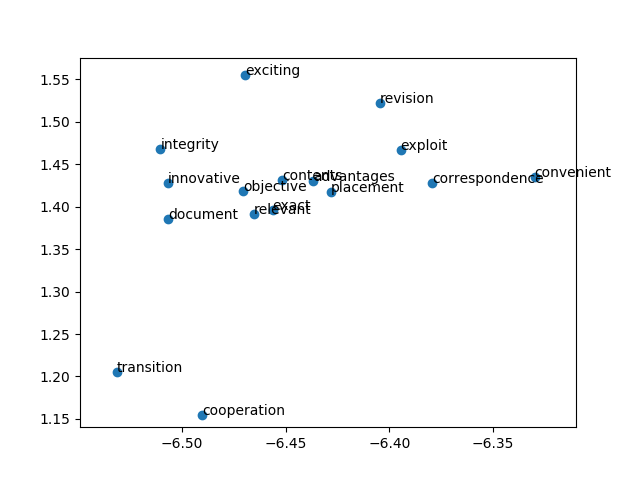

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib notebook
import sys  

reload(sys)  
sys.setdefaultencoding('utf8')
#W contains embeding vectors as rows
# words contains the word labels in the same order as the rows of W

words = vectors_pretrained.keys()
W = vectors_pretrained.values() 

#words, W = zip(*vectors.items())



tsne = TSNE(n_components=2, random_state = 0)
np.set_printoptions(suppress=True)
#Y = tsne.fit_transform(W[:1000,:])
Y = tsne.fit_transform(W[:5000])

plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext = (0, 0),
        textcoords='offset points')

plt.show()



Adjectives with positive connotation seem to be grouped together. (integrity, exciting, relevant, exact, objective, convenient, etc.)

In [11]:
#type(W[:1000,:])
len(W)

400000

In [34]:
Q=[(1,2),(3,4),(5,6),(7,8),(9,10),(11,142),(13,14),(15,16),(17,118),(19,20)]
Q[:5]


[(1, 2), (3, 4), (5, 6), (7, 8), (9, 10)]

In [24]:
(np.array(vectors_pretrained['paris']) - 
         np.array(vectors_pretrained['france']) + 
         np.array(vectors_pretrained['england']))

array([-0.25747   ,  0.77648   , -1.2       , -0.75063   ,  0.01871   ,
       -0.98284193, -1.45891   ,  0.61566   , -0.64048   , -0.40088   ,
       -0.84661   ,  0.21069   , -0.8023    , -0.70468   ,  0.15743   ,
        0.77785   ,  0.486246  , -0.07753   , -1.931     ,  0.6049    ,
        1.597117  ,  1.25349   , -0.161807  ,  0.84871   , -0.0815803 ,
       -0.8118    ,  0.23373   , -0.16136   , -0.5647    ,  0.20074   ,
        2.3289    , -0.09939   ,  1.0079    , -0.716227  ,  1.12996   ,
        0.34489   ,  1.01209   ,  0.39882   ,  0.51357   , -0.2847    ,
       -0.18389   , -0.347373  , -0.708588  ,  0.74983   , -0.137956  ,
        1.228575  , -0.26713   , -1.06051   ,  0.68642   , -0.59511   ])

In [23]:
(np.array(vectors_pretrained['london']))

array([ 0.032886 ,  0.99637  , -0.6975   , -0.58375  ,  0.053403 ,
       -0.35758  , -0.96735  , -0.048156 , -0.23417  , -0.31642  ,
       -0.080246 ,  0.0075121, -0.69211  , -0.19357  ,  0.040528 ,
        0.74492  ,  0.079019 , -0.13893  , -1.5938   ,  0.33824  ,
        2.5535   ,  0.87576  , -0.1597   ,  0.85763  , -0.68158  ,
       -1.3948   ,  0.13189  ,  0.10129  , -0.7461   ,  0.67386  ,
        2.5619   , -0.19922  ,  0.76751  , -0.4867   ,  0.39738  ,
       -0.6253   ,  0.63504  , -0.1989   , -0.0953   , -0.22472  ,
        0.61698  , -0.21968  ,  0.2584   , -0.39371  ,  0.47571  ,
        0.57736  , -0.55713  , -0.6259   ,  0.60789  , -0.30978  ])

In [39]:
sum(np.array(vectors_pretrained['verplank']))
correlation_mat= np.corrcoef(np.array(vectors_pretrained['london']),(np.array(vectors_pretrained['paris']) - 
         np.array(vectors_pretrained['france']) + 
         np.array(vectors_pretrained['england'])))

correlation_mat[0][1]

0.8193409891407949

In [41]:
correlation_mat= np.corrcoef(np.array(vectors_pretrained['queen']),(np.array(vectors_pretrained['king']) - 
         np.array(vectors_pretrained['man']) + 
         np.array(vectors_pretrained['woman'])))
correlation_mat[0][1]


0.86085977307525285

In [45]:
asdf = [5,1,45,7,27,9,3]
wow = sorted(Q, key=lambda x: x[1], reverse=True)
print wow


[(11, 142), (17, 118), (19, 20), (15, 16), (13, 14), (9, 10), (7, 8), (5, 6), (3, 4), (1, 2)]


In [10]:
vectors_pretrained["republican"]

[-0.62964,
 -0.41852,
 1.0236,
 -0.20629,
 0.18681,
 1.1836,
 -1.1125,
 0.061848,
 -0.98647,
 -1.1978,
 -2.0101,
 -0.81715,
 -0.088324,
 0.2431,
 -0.94952,
 -0.62524,
 0.56778,
 -0.66119,
 0.23107,
 -0.732,
 -0.75439,
 -0.54928,
 0.3512,
 -0.44388,
 -0.28215,
 -2.4233,
 -0.15651,
 -0.31636,
 -0.45465,
 0.63483,
 2.0342,
 -0.033718,
 -1.1777,
 -1.2411,
 -0.32364,
 -1.0717,
 -1.0004,
 0.28567,
 -0.45446,
 -0.9771,
 -0.70622,
 0.85814,
 -1.5202,
 0.23351,
 -0.38033,
 0.2903,
 -1.2494,
 -0.17779,
 -0.31254,
 1.2733]